In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objs as go

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import Duration
from ostk.physics.time import Interval
from ostk.physics.time import DateTime
from ostk.physics.coordinate.spherical import LLA
from ostk.physics.coordinate import Frame
from ostk.physics import Environment
from ostk.physics.environment.objects.celestial_bodies import Earth

from ostk.astrodynamics import Trajectory
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory.orbit.models import Kepler
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE
from ostk.astrodynamics.trajectory.orbit.models import SGP4
from ostk.astrodynamics.trajectory.orbit.models.sgp4 import TLE

from utils import propagator, convertState
from models import keplerianDynamics, keplerianJacobian

In [80]:
environment = Environment.default()

In [81]:
epoch = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
earth = environment.access_celestial_object_with_name("Earth")

start_instant = Instant.date_time(DateTime(2020, 1, 1, 0, 0, 0), Scale.UTC)
end_instant   = Instant.date_time(DateTime(2020, 1, 1, 1, 0, 0), Scale.UTC)
interval = Interval.closed(start_instant, end_instant)
step = Duration.minutes(1.0)
instants = interval.generate_grid(step)

In [82]:
def convert_state (instant, state):
    
    lla = LLA.cartesian(state.get_position().in_frame(Frame.ITRF(), state.get_instant()).get_coordinates(), Earth.equatorial_radius, Earth.flattening)
    
    return [
                repr(instant),
                float(instant.get_modified_julian_date(Scale.UTC)),
                *state.get_position().get_coordinates().transpose()[0].tolist(),
                *state.get_velocity().get_coordinates().transpose()[0].tolist(),
                float(lla.get_latitude().in_degrees()),
                float(lla.get_longitude().in_degrees()),
                float(lla.get_altitude().in_meters())
            ]

In [83]:
G = {}

a0 = Length.kilometers(7000.0)
e0 = 0.0001
i0 = Angle.degrees(35.0)
raan0 = Angle.degrees(40.0)
aop0 = Angle.degrees(45.0)
nu0 = Angle.degrees(50.0)
G['0'] = [a0, e0, i0, raan0, aop0, nu0]

#Satellite GPS1
a1 = Length.kilometers(26559.8)
e1 = 10**-7
i1 = Angle.degrees(55.0)
raan1 = Angle.degrees(48.85)
aop1 = Angle.degrees(0.0)
nu1 = Angle.degrees(83.29)
G['1'] = [a1, e1, i1, raan1, aop1, nu1]

#Satellite GPS2
a2 = Length.kilometers(26559.8)
e2 = 10**-7
i2 = Angle.degrees(55.0)
raan2 = Angle.degrees(48.85)
aop2 = Angle.degrees(0.0)
nu2 = Angle.degrees(343.21)
G['2'] = [a2, e2, i2, raan2, aop2, nu2]

#Satellite GPS3
a3 = Length.kilometers(26559.8)
e3 = 10**-7
i3 = Angle.degrees(55.0)
raan3 = Angle.degrees(48.85)
aop3 = Angle.degrees(0.0)
nu3 = Angle.degrees(311.08)
G['3'] = [a3, e3, i3, raan3, aop3, nu3]

#Satellite GPS4
a4 = Length.kilometers(26559.8)
e4 = 10**-7
i4 = Angle.degrees(55.0)
raan4 = Angle.degrees(48.85)
aop4 = Angle.degrees(0.0)
nu4 = Angle.degrees(212.97)
G['4'] = [a4, e4, i4, raan4, aop4, nu4]

n = len(G)
num_gps = n-1

def orbit_gen(G, k):
    a, e, i, raan, aop, nu = G[str(k)]
    coe = COE(a, e, i, raan, aop, nu)
    model = Kepler(coe, epoch, earth, Kepler.PerturbationType.No)
    orbit = Orbit(model, earth)
    
    states = [[orbit.get_state_at(instant)] for instant in instants]
    states = np.array([[orbit.get_state_at(instant).get_position().get_coordinates().transpose()[0]] for instant in instants])
    
    states_ints = [[instant, orbit.get_state_at(instant)] for instant in instants]
    orbit_data = [convert_state(instant, state) for [instant, state] in states_ints]
    orbit_data = np.array(orbit_data)
    orbit_df = pd.DataFrame(orbit_data, columns= \
    ['$Time^{UTC}$', '$MJD^{UTC}$', '$x_{x}^{ECI}$', '$x_{y}^{ECI}$', '$x_{z}^{ECI}$', '$v_{x}^{ECI}$', '$v_{y}^{ECI}$', '$v_{z}^{ECI}$', '$Latitude$', '$Longitude$', '$Altitude$'])
    return states, orbit, orbit_df

states = np.zeros((num_gps, 3, len(instants)))
orbit = []
for i in range(1,n):
    states_i, orbit_i, _ = orbit_gen(G, i)
    states[i-1, :,  :] = np.squeeze(np.array(states_i)).T
    orbit.append(orbit_i)
print(states.shape)

(4, 3, 61)


In [84]:
coe1 = COE(a1, e1, i1, raan1, aop1, nu1)
model1 = Kepler(coe1, epoch, earth, Kepler.PerturbationType.No)
orbit1 = Orbit(model1, earth)
model1.get_perturbation_type()
model1.get_classical_orbital_elements()

-- Classical Orbital Elements ----------------------------------------------------------------------
    Semi-major axis:                         26559800.0 [m]                           
    Eccentricity:                            9.9999999999999995e-08                   
    Inclination:                             55.0 [deg]                               
    Right ascension of the ascending node:   48.850000000000001 [deg]                 
    Argument of periapsis:                   0.0 [deg]                                
    True anomaly:                            83.290000000000006 [deg]                 
----------------------------------------------------------------------------------------------------

In [85]:
orbit_df = {}

for i in range(n):
    orbit_df[str(i)] = orbit_gen(G, i)

In [86]:
figure = go.Figure()

for i in range(n):
    
    _, _, orbit_sat = orbit_df[str(i)]
    color = 'blue'
    
    if i == 0:
        color = 'red'
    
    figure.add_trace(go.Scattergeo(
            lon = orbit_sat['$Longitude$'],
            lat = orbit_sat['$Latitude$'],
            mode = 'lines',
            line = go.scattergeo.Line(
                width = 1,
                color = color
            )
        ))

    
    
figure.update_layout(
        title = None,
        showlegend = False,
        height=1000,
        geo = go.layout.Geo(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)'
        )
    )

figure.show()

In [91]:
import numpy as np
from scipy.linalg import sqrtm
import scipy.sparse as sp
import scipy.sparse.linalg as spln



def g(X_gps_t, X_t):
    return np.linalg.norm(X_gps_t - X_t[:3].T, axis = 1)

def w(dim, Cov):
    return np.random.multivariate_normal(np.zeros(dim), Cov)

def generateMeasurements(X_gps, X, R, noise=True):
    m, T = X_gps.shape[0], X.shape[0]
    Y = np.zeros((T,m))
    for t in range(T):
        Y[t,:] = g(X_gps[:,:,t], X[t,:])
            
        if noise:
            Y[t,:] += w(m, R)
    
    return Y

def jacobianMeasurements(X_gps_t, X_t):
    num_sat = X_gps_t.shape[0]
    norm = np.linalg.norm(X_gps_t - X_t[:3].T, axis = 1, keepdims = True)
    C = (X_t[:3].T - X_gps_t)/norm
    C = np.concatenate((C, np.zeros((num_sat, 3))), axis = 1)
    return C


def EKF(X, Y, X_gps, mu0, Sigma0, Q, R, fDynamics, fMeas, JMeas, JDynamics, propagator, dt):
    """
    Extended Kalman Filter.
    """
    T, n = X.shape

    mu = np.zeros((T, n))
    Sigma = np.zeros((T, n, n))
    A = np.zeros((T, n, n))

    mu[0,:] = mu0
    Sigma[0,:,:] = Sigma0
    A[0,:,:] = JDynamics(mu[0,:])

    for t in range(1,T):
        #--- Predict ---#
        mu[t,:] = propagator(mu[t-1,:], dt, fDynamics)
        Sigma[t,:,:] = np.dot(A[t-1,:,:], np.dot(Sigma[t-1,:,:], A[t-1,:,:].T))
        Sigma[t,:,:] += Q

        A[t,:,:] = JDynamics(mu[t,:])

        #--- Update ---#
        C = JMeas(X_gps[:,:,t], mu[t,:])
        K = np.dot(Sigma[t,:,:], np.dot(C.T, np.linalg.inv(np.dot(C,Sigma[t,:,:]).dot(C.T) + R)))
        mu[t,:] += np.dot(K, Y[t,:] - fMeas(X_gps[:,:,t], mu[t,:]))
        Sigma[t,:,:] -= np.dot(K, np.dot(C, Sigma[t,:,:]))
        
    return mu, Sigma

In [92]:
X0 = np.array(convertState(orbit[0].get_state_at(instants[0])))
dt = step.in_seconds()

X_kepler = np.zeros((len(instants), 6))
X_kepler[0,:] = X0
for t in range(1,len(instants)):
    X_kepler[t,:] = propagator(X_kepler[t-1,:], dt, keplerianDynamics)
    
# Covariance of process noise
Q = np.diag([1000, 1000, 1000, 10, 10, 10])

# Covariance of measurement noise
R = np.diag([1000, 1000, 1000, 1000])

#Process noise
X_kepler_noisy = X_kepler + np.random.multivariate_normal(np.zeros(6),Q,len(instants))

# Generate noisy measurements
Y_kepler = generateMeasurements(states, X_kepler_noisy, R, noise=True)

# Initial mean and covariance
mu0 = X0
Sigma0 = np.diag([1000, 1000, 1000, 10, 10, 10])

/home/jovyan/utils.py:12: RuntimeWarning:

overflow encountered in multiply



In [93]:
mu, _ = EKF(X=X_kepler_noisy, Y=Y_kepler, X_gps = states, 
            mu0=mu0, Sigma0=Sigma0,
            Q=Q, R=R,
            fDynamics=keplerianDynamics,
            fMeas=g,
            JMeas = jacobianMeasurements,
            JDynamics=keplerianJacobian,
            propagator=propagator,
            dt=dt
           )

[Text(0, 0.5, '$v_k^{ECI}$'), Text(0.5, 0, 'Time (sec)')]

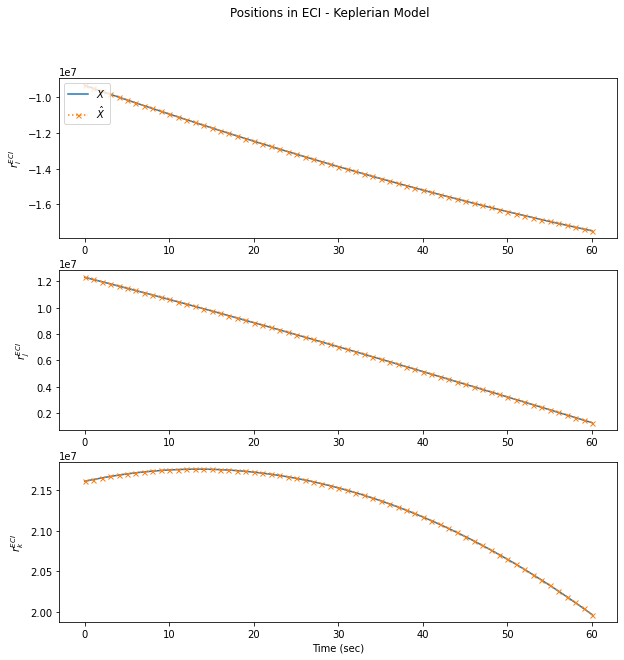

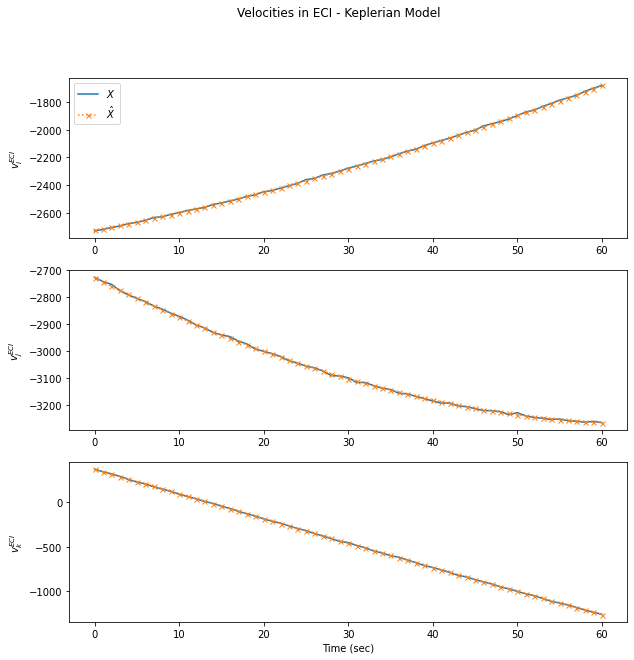

In [94]:
fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Positions in ECI - Keplerian Model')
axs[0].plot(X_kepler_noisy[:,0], label="$X$")
axs[0].plot(mu[:,0], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$r_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler_noisy[:,1])
axs[1].plot(mu[:,1], ':x', ms=5)
axs[1].set(ylabel="$r_j^{ECI}$")
axs[2].plot(X_kepler_noisy[:,2])
axs[2].plot(mu[:,2], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$r_k^{ECI}$")

fig, axs = plt.subplots(3, figsize=(10,10))
fig.suptitle('Velocities in ECI - Keplerian Model')
axs[0].plot(X_kepler_noisy[:,3], label="$X$")
axs[0].plot(mu[:,3], ':x', ms=5, label="$\hat{X}$")
axs[0].set(ylabel="$v_i^{ECI}$")
axs[0].legend(loc="upper left")
axs[1].plot(X_kepler_noisy[:,4])
axs[1].plot(mu[:,4], ':x', ms=5)
axs[1].set(ylabel="$v_j^{ECI}$")
axs[2].plot(X_kepler_noisy[:,5])
axs[2].plot(mu[:,5], ':x', ms=5)
axs[2].set(xlabel="Time (sec)", ylabel="$v_k^{ECI}$")